***WHATSAPP ANALYZER: CHAT MÁSTER BIG DATA***

MIREN OSTOLAZA Y MARÍA GARCÍA


In [29]:
import io
import sys

    
def replace_bad_character(line):
    return line.strip().replace(u"\u202a", "").replace(u"\u200e", "").replace(u"\u202c", "").replace(u"\xa0", " ")

try: 
    filepath = raw_input("Please input the chat filepath:")
except NameError:
    filepath = input("Please input chat filepath:")

try:
    with io.open(filepath, "r", encoding="utf-8") as file:
        content = [replace_bad_character(l) for l in file.readlines()]
    
except IOError as e:
    print("File \"" + filepath + "\" not found. Please recheck your file location")
    sys.exit()

common_words = []
cw_filepath = ""

cw_option = "Please select common word file or leave it blank to escape: \n\
    1: Indonesian (id_cw.py)\n\
    2: English (en_cw.py)\n\
    3: Custom file\n\
    4: Skip common word\n\
    5: Spanish (es_cw.py)\n"
try: 
    cw = raw_input(cw_option)
except NameError:
    cw = input(cw_option)
    
if cw == "1":
    cw_filepath = "id_cw"
elif cw == "2":
    cw_filepath = "en_cw"
elif cw == "5":
    cw_filepath = "es_cw"
elif cw == "3":
    """
    Prompt user to input the file path
    """
    try: 
        cw_filepath = raw_input("Please input your common word filepath")
    except NameError:
        cw_filepath = input("Please input your common word filepath")


if len(cw_filepath) > 0:

    try:
        common_words = __import__(cw_filepath, globals(), locals(), [common_words]).common_words
        
    except:
        print("Error getting common word file location")
        sys.exit()
else:
    print("You skipped common word.")

try: 
    verbose = raw_input("You wanna print the verbose mode? y/[N]: ") == "y" or False
except NameError:
    verbose = input("You wanna print the verbose mode? y/[N]: ") == "y" or False


Please input chat filepath:./_chat.txt
Please select common word file or leave it blank to escape: 
    1: Indonesian (id_cw.py)
    2: English (en_cw.py)
    3: Custom file
    4: Skip common word
    5: Spanish (es_cw.py)
5
You wanna print the verbose mode? y/[N]: y


In [23]:
!pip install emoji
!pip install wordcloud
!pip install plotly
!pip install nltk

In [2]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Maria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
import nltk
import re
import datetime
import errno
import pandas as pd
import emoji
import regex
from collections import Counter
from dateutil import parser
import operator
import itertools 
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline


class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
"""
Global vars
"""
chat_of_members = {}
member_chat = {"member": [], "chat_count": []}
attachments = {}
refered_web = {"domain": [], "d_count": []}
popular_words = {}
chat_words = ""
emojis = {"emj_char": [], "char_count": []}
heat_map = {
    "day": [], 
    "hour": [], 
    "chat_count": []
}
deleted_message = 0
pure_chat = ""
total_chat = 0

"""
Starting line mean a line that started with date time.
Because there are multiline chat. I called it following line.
A starting line must be classified before it's data being extracted.
"""
def is_starting_line(line):
    pattern = r"""
        (\[?)       #Zero or one open square bracket '['
        (((\d{1,2})   #1 to 2 digit date
        (/|-)       #'/' or '-' separator
        (\d{1,2})   #1 to 2 digit month
        (/|-)       #'/' or '-' separator
        (\d{2,4}))   #2 to 4 digit of year
        (,?\s)      #Zero or one comma ',' and ingle space
        ((\d{1,2})  #1 to 2 digit of hour
        (:|\.)      #Colon ':' or dot '.' separator
        (\d{2})     #2 digit of minute
        (\.|:)?     #Zero or one of dot '.' or colon ':'
        (\d{2})?    #Zero or one of 2 digits of second
        (\s[AP]M)?))  #Zero or one of ('space', 'A' or 'P', and 'M'
        (\]?\s-?\s?\s?)#Zero or one close square bracket ']', Zero or one (space and '-'), zero or one space
        (.+)        #One or more character of chat member phone number or contact name
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), line)

"""
"Is Chat" means the body of a line is not an event.
May contains attachment
"""
def is_chat(body):
    pattern = r"""
            ([^:]+)#Chat member
            (:)   #Colon separator
            (.+)  #One or more charachter of message content
    """
    
    return re.match(re.compile(pattern, re.VERBOSE), body)

"""
Classify attachment
Note: in Android, there is no proper description wether it's a image, 
      video, audio, gif, or sticker.
"""
def contains_attachment(body):
    pattern_attachment = [
        ".*<Media omitted>$", #English version of android attachment
        ".*<Imagen omitida>$", # EN ESPAÑOL
        ".*<Media tidak disertakan>$", #Indonesia version of android attachment
        ".*Pesan tidak didukung$", #Some device not recognize sticker attachment
        ".+\.vcf \(file\sterlampir\)$", #Indonesian version of android contact card,
        ".+\.vcf \(file\sattached\)$", #Indonesian version of android contact card,
        ".*imagen omitida$",
        ".*video omitido$",
        ".*documento omitido$",
        ".*Tarjeta de contacto omitida$",
        ".*audio omitido$",
        ".*GIF omitido$",
        ".*sticker omitido$"
    ]
    
    for p in pattern_attachment:
        match = re.match(p, body)
        if match:
            return body
    return None

"""
Event means logs of chat activity e.g member left, member added, removed, etc.
This kind of line can not count as a chat
"""
def is_event(body):
    pattern_event = [
        "Messages to this group are now secured with end-to-end encryption\.$",
        ".+\screated this group$",
        ".+\skeluar$",
        ".+\sleft$",
        ".+\stelah bergabung menggunakan tautan undangan grup ini$",
        ".+\smenambahkan\s.+",
        ".+\sadded\s.+",
        ".+\sremoved\s.+",
        ".*You joined using this group's invite links$",
        ".+'s security code changed\.$",
        ".*telah mengganti nomor teleponnya ke nomor baru. Ketuk untuk mengirim pesan atau menambahkan nomor baru\.$",
        ".*changed their phone number to a new number. Tap to message or add the new number\.$"
    ]
    
    for p in pattern_event:
        match = re.match(p, body)
        if match:
            return match
    return None
"""
Deleted message
"""
def is_deleted(body):
    p = [
        ".*This message was deleted\.$",
        ".*Este mensaje fue eliminado\.$",
        ".*Pesan ini telah dihapus$"
    ]
    
    for p in p:
        match = re.match(p, body)
        if match:
            return body
    return None

"""
EXTRACT TIMESTAMP
"""
def extract_timestamp(time_string):
    return parser.parse(time_string)

"""
Check if chat contais a url
"""
def extract_url(body):
    pattern = "https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+"
    
    return re.findall(pattern, body)

def get_domain(str):
    domain = str.replace("http://", '')
    domain = domain.replace("https://", '')
    domain = domain.split("/")
    return domain[0]

"""
EMOJI
"""
def extract_emojis(string):
    emj = []
    
    for c in string:
        
        if c in emoji.UNICODE_EMOJI:
            emj.append(c)

    if len(emj) > 0:
        increment_emoji_count(emj)
    
    return emj



"""
Count top words
"""
def get_words(msg):
    
    #remove non alpha content
    regex = re.sub(r"[^a-z\s]+", "", msg.lower())
    regex = re.sub(r'[^\x00-\x7f]',r'', regex)
    words = regex.split(" ")
    
    for x in words:
        if x:
            rank_word(x)
            
    return words

def rank_word(word):
    
    if not word in common_words:
        popular_words[word] = popular_words.get(word, 0) + 1
        global chat_words
        chat_words += " {0}".format(word)
        
    return word
    
"""
Counting function
"""

"""
Rank the 'Most Active user'
"""        
def increment_chat_count(member):
    member_chat["member"].append(member)
    member_chat["chat_count"].append(1)
    global total_chat
    total_chat += 1
    
    return member
 
def increment_attachment_count(message):
    
    if "imagen omitida" in message:
        attachments["image"] = attachments.get("image", 0) +1
        return
        
    if "video omitido" in message:
        attachments["video"] = attachments.get("video", 0) +1
        return
    
    if "audio omitido" in message:
        attachments["audio"] = attachments.get("audio", 0) +1
        return
    
    if "documento omitido" in message:
        attachments["document"] = attachments.get("document", 0) +1
        return
    
    if "Tarjeta de contacto omitida" in message or ".vcf" in message:
        attachments["contact"] = attachments.get("contact", 0) +1
        return
    
    if "GIF omitido" in message:
        attachments["gif"] = attachments.get("gif", 0) +1
        return
    
    if "sticker omitido" in message:
        attachments["sticker"] = attachments.get("sticker", 0) +1
        return
    
    ##Unknown attachment
    attachments["unknown"] = attachments.get("unknown", 0) +1

    

def increment_link_count(urls):
    for url in urls:
        increment_domain_count(get_domain(url))
                    
    return len(urls)
    
def increment_domain_count(domain):
    refered_web["domain"].append(domain)
    refered_web["d_count"].append(1)

def increment_emoji_count(char_list):
    groups = Counter(char_list)
    for c in groups.items():
        emojis["emj_char"].append(c[0])
        emojis["char_count"].append(c[1])
        
def increment_heatmap(dt):
    heat_map["day"].append(dt.strftime("%A"))
    heat_map["hour"].append(dt.strftime("%H"))
    heat_map["chat_count"].append(1)

def increment_deleted():
    global deleted_message
    deleted_message += 1
"""
Self explained
"""
def parse_line(line, verbose):
    prefix = ""
    is_starting = is_starting_line(line)
    
    if is_starting:
        #Check wether the starting line is a chat or an event
        body = is_starting.group(18)
        chat = is_chat(body)
        dt = extract_timestamp(is_starting.group(2).replace(".", ":"))
        increment_heatmap(dt)
        
        if chat:
            has_attachment = contains_attachment(chat.group(3))
            increment_chat_count(chat.group(1))
            message_body = chat.group(3)
            
            
            if has_attachment:
                prefix = "@@@" 
                increment_attachment_count(has_attachment)
                
                if verbose: print(bcolors.OKBLUE + bcolors.HEADER + prefix + line)
                
            else:
                if is_deleted(message_body):
                    increment_deleted()
                else:
                    prefix = "+++"
                    
                    #URL & Domain
                    urls = extract_url(message_body)
                    if urls:
                        increment_link_count(urls)

                    #Emoji
                    emjs = extract_emojis(message_body)
                    
                    #Word Count & Wordcloud
                    get_words(message_body)
                
                    if verbose: print(bcolors.OKGREEN + bcolors.HEADER + prefix + line)
                
        elif is_event(body):
            prefix = "***"
                
            if verbose: print(bcolors.WARNING + prefix + line)
        
    else:
        prefix = "|||"
        
        #URL & Domain
        urls = extract_url(line)
        if urls:
            increment_link_count(urls)
        
        #Emoji    
        emjs = extract_emojis(line)
        
        #Word Count & Wordcloud
        get_words(line)

        if verbose: print(bcolors.FAIL + prefix + line)

print("Extracting data. Please wait....")

for line in content:
    parse_line(line, verbose)
    
print("Done. You can run next cell.")


Extracting data. Please wait....
+++[7/9/20 12:00:24] Master MBD📈: Los mensajes y las llamadas están cifrados de extremo a extremo. Nadie fuera de este chat, ni siquiera WhatsApp, puede leerlos ni escucharlos.
+++[8/9/20 19:19:31] Laura ICAI: Por mi vale!
+++[8/9/20 19:20:01] Santiago ICAI: Por mí bien
+++[8/9/20 19:20:43] Andres ICAI: Yo hoy no puedo . El próximo día fijo
+++[8/9/20 19:21:03] Polo ICAI: Yo igual, me uno a la próxima!
+++[8/9/20 19:21:19] María S. ICAI: Y yoo!
+++[8/9/20 19:22:22] Adiran ICAI: La proxima 100%
+++[8/9/20 19:24:30] Ángel ICAI: Yo igual
+++[8/9/20 19:33:36] Vicky ICAI: Ya sabemos que el jueves estás disponible
+++[9/9/20 10:05:57] Thomas ICAI: Donde esta hoy ?
+++[9/9/20 10:06:15] Guille ICAI: Hoy no hay clase por la mañana
+++[9/9/20 10:06:42] Thomas ICAI: Vale gracias
+++[9/9/20 10:50:19] +34 666 82 82 48: para solicitar lo de Twitter os han pedido esto?
@@@[9/9/20 10:50:32] +34 666 82 82 48: imagen omitida
+++[9/9/20 10:51:10] +34 666 82 82 48: sabéis 

+++[20/9/20 14:46:18] Andres ICAI: Y con este comando :
|||/usr/libexec/java_home -V
|||
|||Deberían poder ver la distintas máquinas virtuales de Java que tienen
+++[20/9/20 15:03:46] Lucia ICAI: Tienes el link para descargar jedit 5.5? Porque solo encuentro 5.6
+++[20/9/20 15:05:02] Andres ICAI: Si entras en el que ella da en los apuntes ,verás que te aparece Justo debajo del 5.6 el 5.5.0.dmg
@@@[20/9/20 15:06:18] Andres ICAI: imagen omitida
+++[20/9/20 15:06:19] Lucia ICAI: Cierto, lo acabo de ver
+++[20/9/20 15:06:22] Lucia ICAI: Gracias!
+++[20/9/20 15:06:33] Andres ICAI: Nada !
+++[20/9/20 15:11:14] Andres ICAI: De todos modos patricia dijo que nos iba a dar algo de código para ejecutar y comprobar que todo iba bien pero al final no ha enviado nada
+++[20/9/20 17:56:49] Vicky ICAI: Gracias 😍
+++[20/9/20 18:56:27] Vicky ICAI: Alguien puede pasar el link de donde descargar la version de java ?
+++[20/9/20 19:36:10] +34 666 82 82 48: no tengo el link, te puedo pasar el archivo .dmg p

+++[4/10/20 12:02:39] Fran ICAI: En el teams tampoco las encuentro, pero tal vez se refiera con notas a los powerpoints
+++[4/10/20 12:03:19] Andres ICAI: No creo la vd ,porque los power estaban subidos ya
+++[4/10/20 12:03:44] Andres ICAI: También pone que dejaba en el chat algunos artículos de esta parte y tampoco sale nada creo
+++[4/10/20 12:03:53] Fran ICAI: Ya, pero se han subido algunas más
+++[4/10/20 12:03:56] +34 661 19 72 74: Creo que se referirá a las notas suyas de filter bubble y lo de open source
+++[4/10/20 12:04:04] Virginia ICAI: Justo
+++[4/10/20 12:04:07] Fran ICAI: Tes
+++[4/10/20 12:04:08] +34 661 19 72 74: Que pone que se subieron hace una hora
+++[4/10/20 12:04:09] Andres ICAI: Pues igual será eso
+++[4/10/20 12:04:13] Fran ICAI: *yes
+++[4/10/20 12:04:21] Andres ICAI: Y he pensado que serían las notas de las entregas estás
+++[4/10/20 12:04:23] Andres ICAI: Graciass
+++[4/10/20 12:09:46] Vicky ICAI: Las entregas esas no van a tener nota
+++[4/10/20 12:10:00] Vi

+++[15/10/20 18:11:21] Aitor ICAI: Podeis decirle que ponga el micro?
+++[15/10/20 18:11:29] Aitor ICAI: No se oye
+++[15/10/20 18:11:49] Vicky ICAI: desde casa ?
+++[15/10/20 18:11:57] Aitor ICAI: Ya está
+++[15/10/20 18:12:01] Aitor ICAI: Gracias
+++[15/10/20 18:36:11] Eladio ICAI: Que nos pomgan ya el famoso VPN para acceder al edge
+++[15/10/20 18:36:50] Vicky ICAI: Toda la razon
+++[15/10/20 18:36:56] Vicky ICAI: mañana lo pido
+++[15/10/20 18:39:20] Eladio ICAI: Y que Patri deje de quejarse de si estamos calentando la silla en la clase o en casa
+++[15/10/20 18:39:26] Eladio ICAI: Que más le dará a ella
+++[15/10/20 18:40:16] Vicky ICAI: ajajajajaja
+++[15/10/20 18:40:36] Vicky ICAI: vale aunque necesitaria justificar porque a veces preferis quedaros en casa
+++[15/10/20 18:40:59] Vicky ICAI: porque es verdad que somos presenciales y no deberiamos faltar si no es por covid
+++[15/10/20 18:41:17] Eladio ICAI: jaja es verdad
+++[15/10/20 18:47:53] Adiran ICAI: Jajajajaja
@@@[15/10/

+++[20/10/20 14:42:26] Manu ICAI: Q no entiendes de ahi
+++[20/10/20 14:42:33] Fran ICAI: Perfect!
+++[20/10/20 14:42:36] Manu ICAI: Q vas a hacer lo q te salga del coño pq eres la delegada a
+++[20/10/20 14:42:41] Manu ICAI: Es lo qe estás dejando claro no?
+++[20/10/20 14:43:26] Nacho ICAI: @34659238790 para delegado
+++[20/10/20 14:43:31] Vicky ICAI: Manu esta tarde hablamos en clase
+++[20/10/20 14:43:45] Virginia ICAI: Pero a mi ponme en el B porfa
+++[20/10/20 14:43:54] Manu ICAI: Q no hay nada que hablar q el turno para ti Victoria
+++[20/10/20 14:43:54] Virginia ICAI: Ya asume que estoy en el B no?
+++[20/10/20 15:01:18] +34 608 23 24 47: Oye el trabajo extra de gobierno del dato, alguien no tiene pareja y quiere hacerlo conmigo? Que me rentaría mazo dividirlo
+++[20/10/20 15:01:38] Lucia ICAI: Yo estoy en el grupo b. Alguien más del a quiere cambiarse al b?
+++[20/10/20 15:02:16] Vicky ICAI: Chicos de los cambios que me habeis escrito antes
+++[20/10/20 15:02:22] Vicky ICAI: p

+++[11/11/20 11:41:50] Edu ICAI: Igual podiamos ponerla el ultimo dia de clase, como decia JL
+++[11/11/20 11:42:02] Vicky ICAI: Poned sugerencias
+++[11/11/20 11:42:07] Vicky ICAI: Y hago una encuesta
+++[11/11/20 11:49:33] +34 649 24 02 34: Los del doble ya tenemos un examen el sábado 19 (que no se puede cambiar porque es común para todo segundo de máster), así que tendría que ser el martes 22 u otro día que cuadremos
+++[11/11/20 11:50:23] +34 659 01 22 44: Casos de estudio no es anual?
+++[11/11/20 12:03:49] +34 666 82 82 48: a mi el 22 me parece bien
+++[11/11/20 12:03:52] Vicky ICAI: Podemos sugerir o martes 22 o último día de clase
+++[11/11/20 12:07:47] +34 649 24 02 34: Por nosotros perfecto, gracias!
@@@[11/11/20 17:39:17] Vicky ICAI: imagen omitida
+++[11/11/20 17:41:21] Vicky ICAI: https://forms.gle/vWcAc92NLh73B5Vv8
+++[11/11/20 17:41:31] Vicky ICAI: LINK para votar la fecha del examen de casos de estudio
+++[11/11/20 17:42:05] Vicky ICAI: he añadido la opcion me da igual 

+++[6/12/20 20:23:43] Santiago ICAI: Ah
+++[6/12/20 20:23:55] Santiago ICAI: Que feliz me acabas de hacer
+++[6/12/20 20:25:04] Vicky ICAI: 🤗🤗
+++[6/12/20 21:56:47] +34 666 82 82 48: a que hora es cada examen final?
+++[6/12/20 22:03:43] Vicky ICAI: Machine a las 17h
+++[6/12/20 22:03:49] Vicky ICAI: Y los otros a las 15h
+++[6/12/20 22:07:42] +34 666 82 82 48: ok gracias!
+++[8/12/20 14:13:42] Mery ICAI: Seria posible pedirle a patricia que suba el examen final del año pasado?
+++[8/12/20 14:13:46] Mery ICAI: Por hacerme una idea
+++[8/12/20 14:14:15] Vicky ICAI: sii
+++[8/12/20 14:14:18] Vicky ICAI: la escribo ahora
+++[8/12/20 14:15:27] Mery ICAI: Graciaaas
+++[8/12/20 14:15:31] Mery ICAI: Y otra duda
+++[8/12/20 14:15:42] Mery ICAI: Hay que aprobar las dos partes del examen?
+++[8/12/20 14:15:45] Mery ICAI: O hacen media
+++[8/12/20 14:16:22] Mery ICAI: Porque es que a mi aprobar la parte de jorge sin haber dado python en mi vida lo veo difícil
+++[8/12/20 14:19:10] Vicky ICAI: Pat

+++[12/1/21 12:34:21] Vicky ICAI: Tengo que dar una respuesta a Jose Luis mañana por la mañana por lo que solo se podrá votar hoy
+++[12/1/21 12:34:35] Andres ICAI: Cuales ?
+++[12/1/21 12:34:39] Vicky ICAI: de los cambios*
@@@[12/1/21 12:36:13] Vicky ICAI: imagen omitida
+++[12/1/21 12:39:33] Vicky ICAI: ⭕️ *CAMBIO 1*
|||Lunes y martes empezar a las 15:20 y no hacer descanso
|||
|||⭕️ *CAMBIO 2*
|||Cambiar Trabajo de Fin de Máster al martes de 17h a 19h
|||Es decir, el martes tendríamos clase de 3 a 7 y los miércoles de 5 a 9
+++[12/1/21 12:45:14] Vicky ICAI: https://forms.gle/wY5JgG9LHe5tf6nY8
+++[12/1/21 12:45:44] Vicky ICAI: ya esta la encuesta, he añadido la opcion me da igual en los dos cambios asi que os pido que voteis por favor
+++[12/1/21 12:46:19] Andres ICAI: Gracias
@@@[12/1/21 13:00:37] Vicky ICAI: imagen omitida
@@@[12/1/21 17:13:57] Vicky ICAI: imagen omitida
+++[12/1/21 17:14:23] Vicky ICAI: Ya no hay encuesta 🙃
+++[12/1/21 17:14:32] Andres ICAI: Vamos que lo único que

+++[16/2/21 16:52:38] Virginia ICAI: Gracias 🙏
+++[17/2/21 12:05:30] Vicky ICAI: Hola Luis,
|||
|||Te quería preguntar si es posible que las pruebas de visualización se realicen al día siguiente de terminar el temario. Hay algunos alumnos que no les da tiempo a llegar a las 3:20  y tienen que ver parte de la clase en diferido mas tarde, por lo que realizarlas el mismo día que se acaba el temario les hace no llevar el temario completo visto.
|||
|||Gracias
|||
|||Victoria
+++[17/2/21 12:05:39] Vicky ICAI: Ok, tiene sentido. No lo había pensado. Gracias por hacérmelo notar Virginia. Lo haremos el martes entonces.
|||
|||Luis f.
+++[17/2/21 12:06:03] Vicky ICAI: Examen de visualizacion el martes
+++[17/2/21 12:06:16] Raquel ICAI: Genial !! Muchas gracias !
+++[17/2/21 12:06:46] Virginia ICAI: Genial, gracias vicky!
Done. You can run next cell.


**DataFrame:**

In [31]:
chat_per_member = (pd.DataFrame(member_chat)
                     .groupby(["member"])
                     .sum()
                     .sort_values(by = ['chat_count'], ascending=False))
popular_words_df = sorted(popular_words.items(), key=operator.itemgetter(1), reverse=True)
domains = (pd.DataFrame(refered_web)
                     .groupby(["domain"])
                     .sum()
                     .sort_values(by = ['d_count'], ascending=False))
emojis_df = (pd.DataFrame(emojis)
                     .groupby(["emj_char"])
                     .sum()
                     .sort_values(by = ['char_count'], ascending=False))
top_repeated_emoji = (pd.DataFrame(emojis)
                     .sort_values(by = ['char_count'], ascending=False))
heatmap_df = pd.DataFrame(heat_map)
grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'], columns=['hour'])

print("Done. You can run next cell.")

Done. You can run next cell.


**Members activity:**

C:\Users\A9049\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 128200 missing from current font.

C:\Users\A9049\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning:

Glyph 128200 missing from current font.



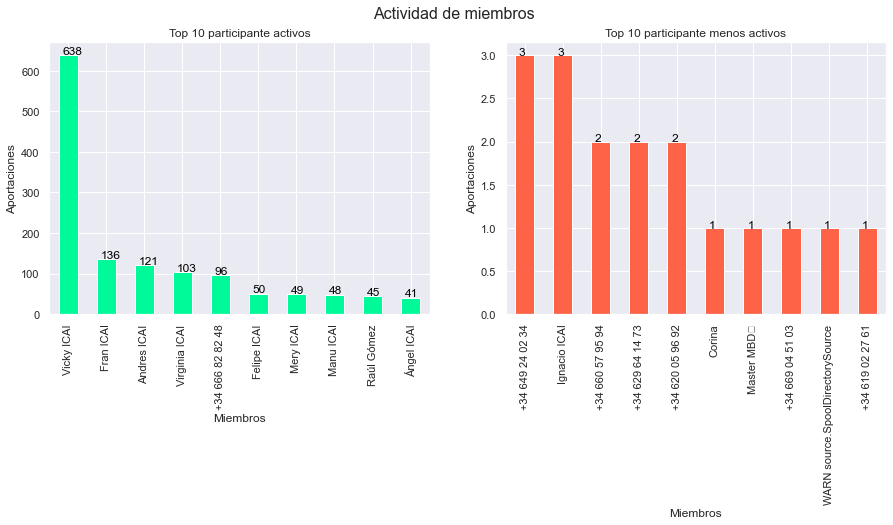

In [32]:

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Actividad de miembros', fontsize=16)





top_member = chat_per_member.head(10)
if not top_member.empty:
    sns.set()
    
    member_plot = top_member.plot(ax=axes[0],kind='bar', legend=None,  facecolor='mediumspringgreen')
    member_plot.set_title("Top 10 participante activos", fontsize=12)
    member_plot.set_xlabel("Miembros")
    member_plot.set_ylabel("Aportaciones")
    for i, v in enumerate(top_member["chat_count"]):
        member_plot.text(i - .15, v + 3, v, color="#000000")
else:
    print("This chat has no member")






bottom_member = chat_per_member.tail(10)
if not bottom_member.empty:
    
    sns.set()
    
    bottom_member_plot = bottom_member.plot(ax=axes[1],kind='bar', legend=None,  facecolor='tomato')
    bottom_member_plot.set_title("Top 10 participante menos activos", fontsize=12)
    bottom_member_plot.set_xlabel("Miembros")
    bottom_member_plot.set_ylabel("Aportaciones")
    for i, v in enumerate(bottom_member["chat_count"]):
        bottom_member_plot.text(i - .15, v , v, color="#000000")
else:
    print("This chat has no member")




**Heatmap:**

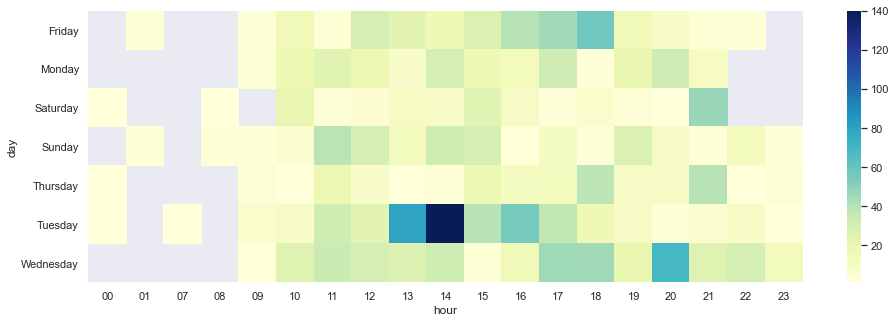

In [33]:
heatmap_df = pd.DataFrame(heat_map)
if not heatmap_df.empty:
    grouped_heatmap = heatmap_df.groupby(["day", "hour"]).sum().sort_values(by=["chat_count"], ascending=False)
    pivoted_heatmap = pd.pivot_table(grouped_heatmap, values='chat_count', index=['day'],columns=['hour'])
    plt.figure(figsize = (16,5))
    sns.heatmap(pivoted_heatmap, 
                annot=False, 
                cmap="YlGnBu",
                cbar=True
               )
else:
    print("This chat does not contain any datetime")


**Active hours of the WhatsApp Group:**

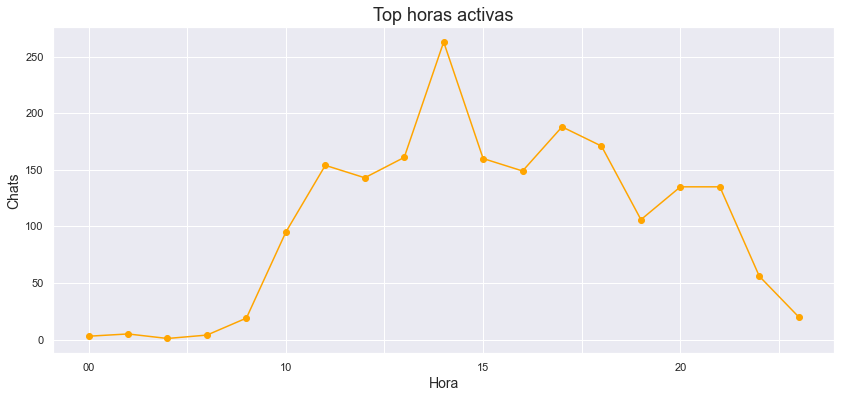

In [35]:
from pandas import DataFrame
type(heat_map["hour"])
df = DataFrame(heat_map["hour"],columns=['Hour'])
top_hour = df['Hour'].value_counts()
top_hour = top_hour.sort_index()


if not top_hour.empty:
    sns.set()
    hour_plot = top_hour.plot(kind='line', legend=None,  figsize=(14, 6), color='orange', marker='o')
    hour_plot.set_title("Top horas activas", fontsize=18)
    hour_plot.set_xlabel("Hora", fontsize=14)
    hour_plot.set_ylabel("Chats",fontsize=14)
    for i, v in enumerate(top_hour):
        member_plot.text(i - .15, v + 3, v, color="#004d40")
else:
    print("This chat has no hours")



**Active weekdays:**

In [36]:
import plotly
import plotly.express as px

heatmap_df = pd.DataFrame(heat_map)


day = heatmap_df.groupby(["day"]).sum()
day.reset_index(inplace=True)

fig = px.line_polar(day, r='chat_count', theta='day', line_close=True, title=" Actividad por día de la semana")
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0,900]
    )),
  showlegend=False
)
fig.show()

**Type of attachments sent:**

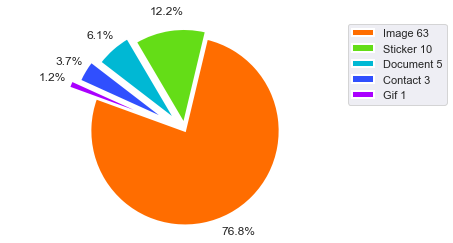

In [37]:
s_attachments = sorted(attachments.items(), key = operator.itemgetter(1), reverse=True)
if s_attachments:
    at_labels = [x[0].title() + " " + str(x[1]) for x in s_attachments]

    at_explode = tuple([0 + i * 0.1 for i in range(len(s_attachments))])
    at_sizes = [x[1] for x in s_attachments]
    at_colors = ["#FF6D00", "#64DD17", "#00B8D4", "#304FFE", "#AA00FF", "#d50000", "#546E7A", "#dddddd"]
    at_pie = plt.pie(at_sizes,  
             autopct='%1.1f%%',
             explode=at_explode,
             pctdistance=1.2,
             colors=at_colors,
             startangle=160,
             radius=1.3,
             wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' },
    )

    at_centre_circle = plt.Circle((0,0),0,color='white', fc='white',linewidth=1.25)
    at_fig = plt.gcf()
    at_fig.gca().add_artist(at_centre_circle)

    plt.legend(
        loc='upper left',
        labels=at_labels,
        prop={'size': 11},
        bbox_to_anchor=(1, 1)
    )
    at_axis = plt.axis('equal')
else:
    print("This chat contains no attachment.")

**Top Website:**

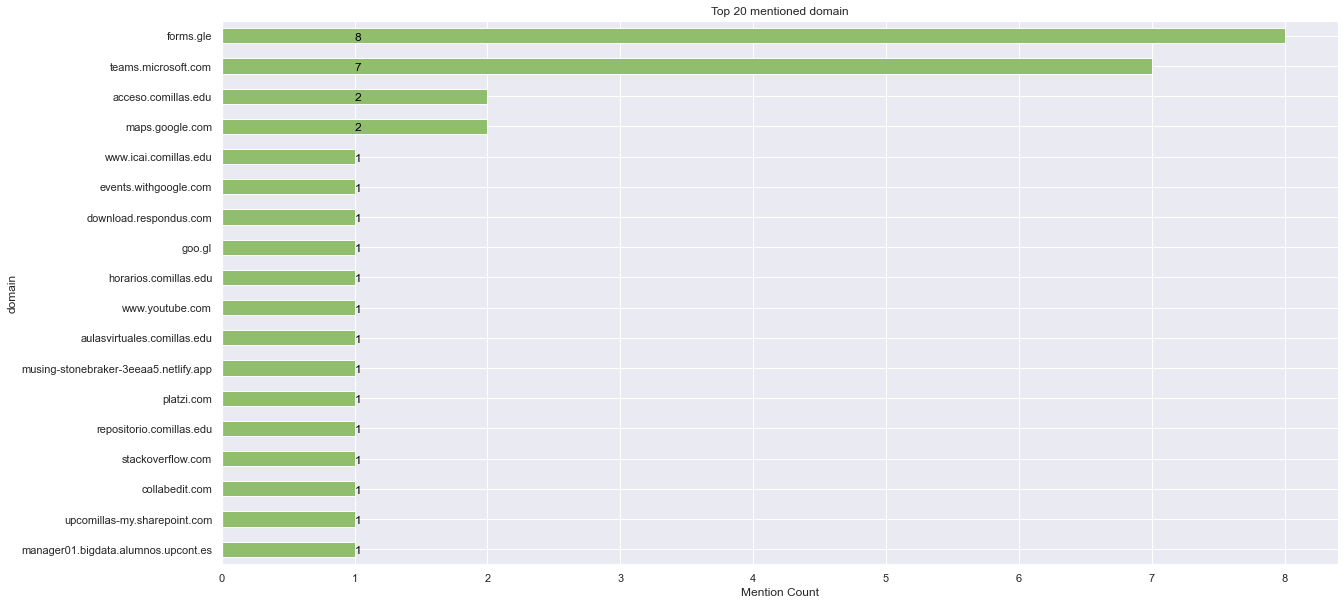

In [38]:
top_web = domains.head(20).sort_values("d_count")
if not top_web.empty:
    mpl.rc('font', **{'sans-serif' : 'arial', 'family' : 'sans-serif'})
    web_plot = top_web.plot(kind='barh', legend=None, title="Top 20 mentioned domain", figsize=(20,10), color="#90BE6D")
    web_plot.set_xlabel("Mention Count")
    for i, v in enumerate(top_web["d_count"]):
        web_plot.text(1, i - .15, v, color="black")
else:
    print("This chat not contains any link")

**Wordcloud:**

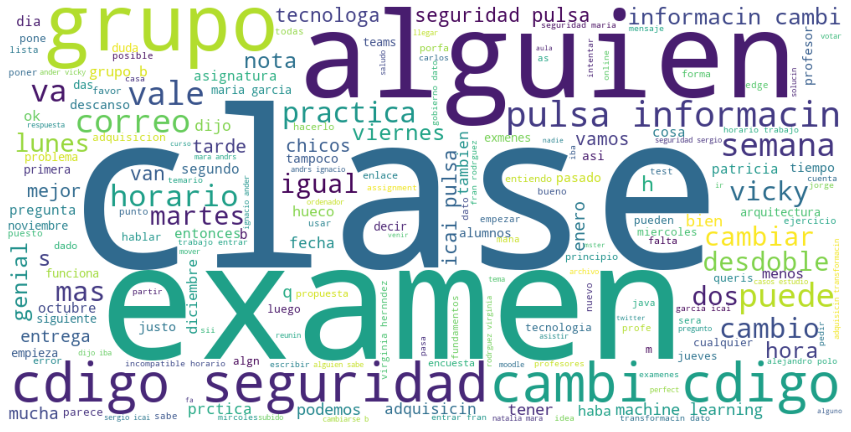

In [39]:

from nltk.corpus import stopwords




stopword = nltk.corpus.stopwords.words('spanish')


if chat_words:
    wordcloud = WordCloud(
        stopwords= stopword, #excluimos los stopwords o palabras vacías que no aportar valor 
        width = 1000, 
        height = 500,
        background_color = "white"
    ).generate(chat_words)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
else:
    print("This chat contains no word")
    
    
    


**Top 5 words**

In [40]:
words= chat_words.split()
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

wordlist= words


diccionario=wordListToFreqDict(wordlist)



def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux

freqdict=diccionario
sorted_diccionario= sortFreqDict(freqdict)

df = pd.DataFrame(sorted_diccionario,
                             columns=[ 'count','palabras'])

df2=df.head(5)
df2


,count,palabras
0,121,clase
1,87,examen
2,65,alguien
3,57,grupo
4,56,cdigo


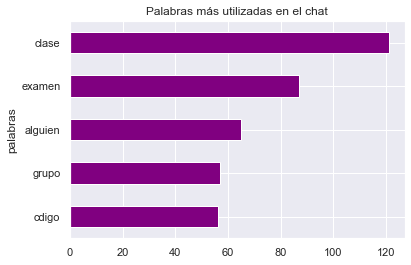

In [41]:

df2.sort_values(by='count').plot.barh(x='palabras',
                      y='count',
                      title= "Palabras más utilizadas en el chat",
                      legend=None,
                      color="purple")



plt.show()






**Swear words**

In [42]:
import csv
palabrotas = pd.read_csv("spanish-bad-words-list_csv-file.csv")
palabrotas = palabrotas.iloc[:, 0]
palabrotas2 = palabrotas.to_frame()
palabrotas2 = palabrotas2.rename(columns={'a tomar por culo':'Palabras'})
palabrotas2['resultado'] = palabrotas2.isin(words)
palabrotas2.head()

,Palabras,resultado
0,a tomar por saco,False
1,anda a cagar,False
2,apestar,False
3,bastardo,False
4,basura,False


In [43]:
palabrotas3 = palabrotas2.groupby(['resultado'])   
palabrotas3.count()

,Palabras
resultado,
False,111
True,5


Se comprueba que se han dicho 5 palabrotas

In [44]:
filtered_df = palabrotas2.query('resultado == True')
filtered_df

,Palabras,resultado
28,coger,True
30,cojones,True
48,huevos,True
52,joder,True
93,puta,True
